Simulate Execution Time: 0.23 seconds



,inter_arrival_times,arrival_times,wait_times,service_start_times,service_times,finish_times,total_spend_times,idle_times
0,14.1508,14.1508,0.0000,14.1508,4.2767,18.4275,4.2767,14.1508
1,4.7709,18.9217,0.0000,18.9217,8.2867,27.2084,8.2867,0.4942
2,36.4295,55.3512,0.0000,55.3512,0.2223,55.5735,0.2223,28.1428
3,7.5601,62.9113,0.0000,62.9113,14.0268,76.9381,14.0268,7.3378
4,4.6392,67.5505,9.3876,76.9381,5.1431,82.0812,14.5307,0.0000
...,...,...,...,...,...,...,...,...
19995,2.4722,135095.0217,22.8064,135117.8281,3.1361,135120.9642,25.9425,0.0000
19996,19.5768,135114.5985,6.3657,135120.9642,0.5092,135121.4734,6.8749,0.0000
19997,5.1212,135119.7197,1.7537,135121.4734,7.3116,135128.7850,9.0653,0.0000
19998,2.8048,135122.5245,6.2605,135128.7850,24.0078,135152.7928,30.2683,0.0000


================================= Calculate from Little's Law Formula =================================

Probablity of the server idle (P0) (1-(𝜆/cµ)): 25.0 %

Probablity of the server busy (𝜆/cµ): 75.0 %

Average interarrival time (𝜆): 6.67 

Average service time (µ): 5.0 

Average waiting queue (Wq): 15.0 minutes

Average spending time in the system (W): 20.0 minutes

Average customer in the queue (Lq): 2.25 customer

Average customer in the system (L): 3.0 customer

================================= Calculate from Simulation =================================

Number of the customer simulation: 20000 

Probablity of the server idle (P0) (1-(𝜆/cµ)): 25.71 %

Probablity of the server busy (𝜆/cµ): 74.29 %

Average interarrival time (𝜆): 6.76 

Average service time (µ): 5.02 

Average waiting queue (Wq): 14.3 minutes

Average spending time in the system (W): 19.32 minutes

Average customer in the queue (Lq): 2.12 customer

Average customer in the system (L): 2.86 customer

Probablity of 

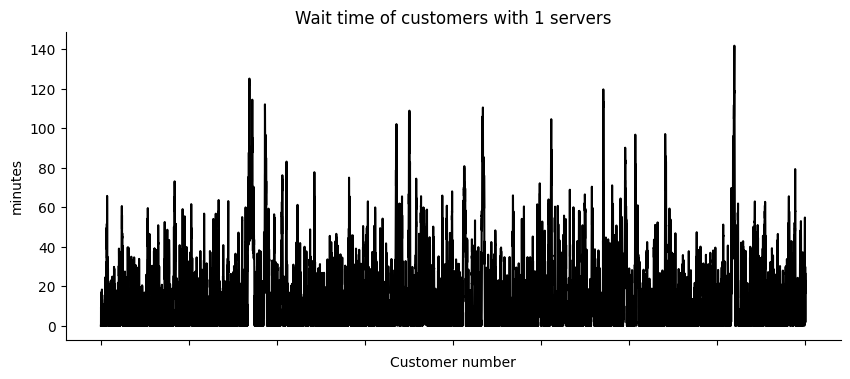

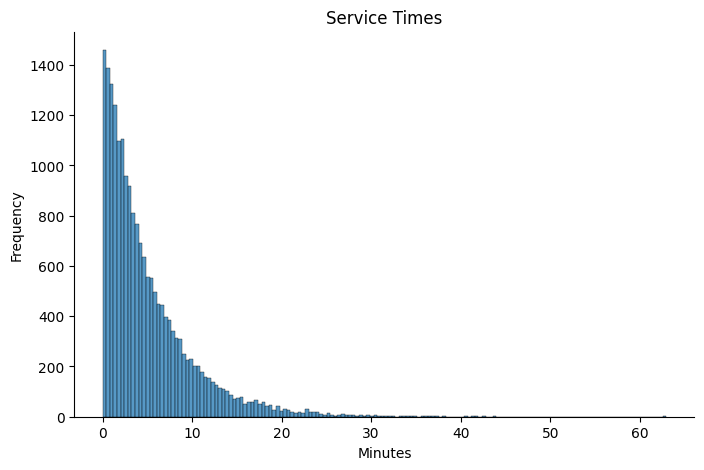

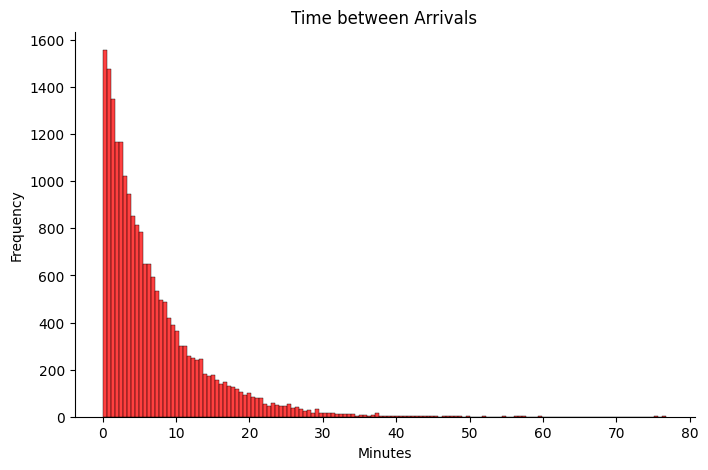

In [7]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import os
import time
import seaborn as sns

class QueueingSystem:
    def __init__(self, arrival_rate, service_rate, simulate_n_customer, rnd_seed, decimal_place):
        self.arrival_rate = arrival_rate  # customer per hour
        self.service_rate = service_rate    # service per hour
        self.simulate_n_customer = simulate_n_customer
        np.random.seed(rnd_seed)
        self.data = pd.DataFrame()
        self.decimal_place = decimal_place
        self.average_arrival_time = None
        self.average_service_time = None
        self.average_waiting_queue_wq = None
        self.average_time_system_w = None
        self.prob_customer_wait = None

    
    def generate_time(self, lambda_rate):
        # convert into minutes per (arrival/service)
        return list(np.round((np.random.exponential(1 / lambda_rate * 60, size=self.simulate_n_customer)), self.decimal_place))


    def generate_table(self, c):
        # generate interarrival times
        interarrival_times = self.generate_time(self.arrival_rate)

        # generate servie times
        service_times = self.generate_time(self.service_rate)
        
        # generate arrival times
        arrival_times = list(np.round(np.cumsum(interarrival_times), self.decimal_place))
        
        # generate finish times
        finish_times = np.zeros(self.simulate_n_customer)
        previous_finish_times = np.zeros(c)
        for i in range(self.simulate_n_customer):
            if i < c:
                finish_times[i] = round((arrival_times[i] + service_times[i]), self.decimal_place)
                previous_finish_times[np.argmin(previous_finish_times)] = finish_times[i]
            else:
                previous_finish = np.min(previous_finish_times)
                finish_times[i] = round((max(arrival_times[i], previous_finish) + service_times[i]), self.decimal_place)
                previous_finish_times[np.argmin(previous_finish_times)] = finish_times[i]

        # generate service start times
        service_start_times = np.round([(finish_times[i] - service_times[i]) for i in range(self.simulate_n_customer)], self.decimal_place) 
        
        # Total time spent in the system by each customer
        total_spend_times = np.round([(finish_times[i] - arrival_times[i]) for i in range(self.simulate_n_customer)], self.decimal_place)
        
        # generate waits times
        wait_times = np.round([(service_start_times[i] - arrival_times[i]) for i in range(self.simulate_n_customer)], self.decimal_place)

        # generate idle times for c = 1 only
        idle_times = np.round([((arrival_times[i] - finish_times[i-1] if (arrival_times[i] > finish_times[i-1]) else 0)  
                      if i > 0 else arrival_times[i]) for i in range(self.simulate_n_customer)], self.decimal_place)
             
        #creating a dataframe 
        self.data = pd.DataFrame({
                                    'inter_arrival_times': interarrival_times,
                                    'arrival_times': arrival_times,
                                    'wait_times': wait_times,
                                    'service_start_times': service_start_times,
                                    'service_times': service_times,
                                    'finish_times': finish_times,
                                    'total_spend_times': total_spend_times,
                                    'idle_times': idle_times,
                                })
        
        if c > 1:
            # generate n server choose
            number_server_choose = np.zeros(self.simulate_n_customer)
            server_mapping = {}
            for i in range(self.simulate_n_customer):
                if i == 0:
                    number_server_choose[i] = 1
                else:
                    if wait_times[i] > 0:
                        best_choose = server_mapping[service_start_times[i]]
                        number_server_choose[i] = best_choose
                    else:
                        if arrival_times[i] < finish_times[i-1]:
                            exclude_n = set()
                            for a in server_mapping:
                                if a > arrival_times[i]:
                                    exclude_n.add(server_mapping[a])
                            best_choose = next(x for x in range(1, c + 1) if x not in exclude_n)
                            number_server_choose[i] = best_choose
                        else:
                            number_server_choose[i] = number_server_choose[i-1]                                  
                server_mapping[finish_times[i]] = number_server_choose[i]
                if len(server_mapping) > c:
                    server_mapping.pop(min(server_mapping, key=lambda x: x))
            self.data["number_server_choose"] = number_server_choose

            # generate idle time for c > 1
            a_temp = None
            for i in range(c):
                new_data = self.data[self.data['number_server_choose'] == i+1]
                idle_n_times = new_data['service_start_times'] - new_data['finish_times'].shift(1)
                idle_n_times[idle_n_times.index[0]] = new_data.service_start_times[idle_n_times.index[0]]
                if max(self.data.finish_times) != new_data.finish_times[new_data.index[-1]]:
                    idle_n_times[idle_n_times.index[-1]] +=  max(self.data.finish_times) - new_data.finish_times[new_data.index[-1]]
                a_temp = pd.concat([a_temp,idle_n_times]) if i > 0 else idle_n_times
            self.data["idle_times"] = a_temp
            
        return self.data

    
    def calculation(self, c):
        #calculate the average waiting time of an arrival (Wq) (in Minutes)
        self.average_waiting_queue_wq = self.data['wait_times'].mean()
        
        # calculate the average time of an arrival in the system (W) (in Minutes)
        # self.average_time_system_w = self.average_waiting_queue_wq + self.average_service_time (alternative calculation)
        self.average_time_system_w = self.data['total_spend_times'].mean()
        
        # calculate the average interarrival time (arrival rate)
        self.average_arrival_time = self.data['inter_arrival_times'].mean()
        
        # calculate the average service time (service rate)
        self.average_service_time = self.data['service_times'].mean()

        # calculate the average customer in system (L) 
        self.average_customer_l = self.data['total_spend_times'].sum() / self.data['finish_times'].iloc[-1]
        
        # calculate the average customer in queue (Lq)
        self.average_customer_lq = self.data['wait_times'].sum() / self.data['finish_times'].iloc[-1]
        
        # calcualate probability of the customer waiting
        self.prob_customer_wait = len(self.data[self.data['wait_times'] > 0]) / self.data.shape[0]

        # calculat probability of the idle server
        self.prob_idle_server = self.data['idle_times'].sum() / (self.data['finish_times'].iloc[-1] * c)
        
        # calculate probability of the server being busy
        self.prob_server_busy = 1 - self.prob_idle_server

    
    def calculate_by_little_formula(self, c):
        #calculate the average waiting time of an arrival (Wq) (in Minutes)
        self.formula_average_waiting_queue_wq = (self.arrival_rate / (self.service_rate * (self.service_rate - self.arrival_rate))) * 60

        # calculate the average time of an arrival in the system (W) (in Minutes)
        self.formula_average_time_system_w = 1 / (self.service_rate - self.arrival_rate) * 60
        
        # calculate the average interarrival time (arrival rate)
        self.formula_average_arrival_time = 1 / self.arrival_rate * 60
        
        # calculate the average service time (service rate)
        self.formula_average_service_time = 1 / self.service_rate * 60

        # calculate the average customer in system (L) 
        self.formula_average_customer_l = self.arrival_rate / (self.service_rate - self.arrival_rate)
        
        # calculate the average customer in queue (Lq)
        self.formula_average_customer_lq = ((self.arrival_rate ** 2) / (self.service_rate * (self.service_rate - self.arrival_rate)))

        # calculate probability of the server being busy
        self.formula_prob_server_busy = self.arrival_rate / (c * self.service_rate)
        
        # calculat probability of the idle server
        self.formula_prob_idle_server = 1 - self.formula_prob_server_busy
        
        
    def display_formula_result(self):
        print("================================= Calculate from Little's Law Formula =================================\n")
        print("Probablity of the server idle (P0) (1-(𝜆/cµ)):", self.display_2decimal(self.formula_prob_idle_server * 100), "%\n")
        print("Probablity of the server busy (𝜆/cµ):", self.display_2decimal(self.formula_prob_server_busy * 100), "%\n")
        print("Average interarrival time (𝜆):", self.display_2decimal(self.formula_average_arrival_time),"\n")
        print("Average service time (µ):", self.display_2decimal(self.formula_average_service_time),"\n")
        print("Average waiting queue (Wq):", self.display_2decimal(self.formula_average_waiting_queue_wq), "minutes\n")
        print("Average spending time in the system (W):", self.display_2decimal(self.formula_average_time_system_w), "minutes\n")
        print("Average customer in the queue (Lq):", self.display_2decimal(self.formula_average_customer_lq), "customer\n")
        print("Average customer in the system (L):", self.display_2decimal(self.formula_average_customer_l), "customer\n")

    
    def display_result(self):
        # print result
        print("================================= Calculate from Simulation =================================\n")
        print("Number of the customer simulation:", self.simulate_n_customer,"\n")
        print("Probablity of the server idle (P0) (1-(𝜆/cµ)):", self.display_2decimal(self.prob_idle_server * 100), "%\n")
        print("Probablity of the server busy (𝜆/cµ):", self.display_2decimal(self.prob_server_busy * 100), "%\n")
        print("Average interarrival time (𝜆):", self.display_2decimal(self.average_arrival_time),"\n")
        print("Average service time (µ):", self.display_2decimal(self.average_service_time),"\n")
        print("Average waiting queue (Wq):", self.display_2decimal(self.average_waiting_queue_wq), "minutes\n")
        print("Average spending time in the system (W):", self.display_2decimal(self.average_time_system_w), "minutes\n")
        print("Average customer in the queue (Lq):", self.display_2decimal(self.average_customer_lq), "customer\n")
        print("Average customer in the system (L):", self.display_2decimal(self.average_customer_l), "customer\n")
        print("Probablity of the customer waiting in queue:", self.display_2decimal(self.prob_customer_wait * 100), "%\n")

        
    def wait_time_graph(self, c):
        plt.figure(figsize=(10,4))
        sns.lineplot(x=self.data.index,y=self.data['wait_times'],color='black').set(xticklabels=[])
        plt.xlabel('Customer number')
        plt.ylabel('minutes')
        plt.title('Wait time of customers with '+str(c)+ ' servers')
        sns.despine()
        plt.show()

    def service_rate_graph(self):
        plt.figure(figsize=(8,5))
        sns.histplot(self.data['service_times'],kde=False)
        plt.title('Service Times')
        plt.xlabel('Minutes')
        plt.ylabel('Frequency')
        sns.despine()
        plt.show()

    def arrival_rate_graph(self):
        plt.figure(figsize=(8,5))
        sns.histplot(self.data['inter_arrival_times'],kde=False,color='r')
        plt.title('Time between Arrivals')
        plt.xlabel('Minutes')
        plt.ylabel('Frequency')
        sns.despine()
        plt.show()

    def display_graph(self, c):
        self.wait_time_graph(c)
        self.service_rate_graph()
        self.arrival_rate_graph()

    def display_2decimal(self, data):
        return np.round(data, 2)
        
    def simulate(self, c=1):
        st = time.time()
        df = self.generate_table(c)
        self.calculation(c)
        self.calculate_by_little_formula(c)
        # get the end time
        et = time.time()
        res = et - st
        print(f"Simulate Execution Time: {res:.2f} seconds\n")
    
    def show_table(self, num = 20):
        display(self.data.head(num))

    def show_all_table(self):
        display(self.data)
    
    def simulate_mmc_rnd(self, rnd_start, rnd_end, max_c):
        for c in range(1, max_c+1):
            
            for i in range(rnd_start, rnd_end + 1):
                np.random.seed(i)
                self.simulate(c)
                if c >= 1:
                    self.display_formula_result()
                    self.display_result()
                    self.show_table(30)
                    self.display_graph(c)


arrival_rate = 9 # per hour
service_rate = 12 # per hour
simulate_number_of_customer = 20000
random_seed = None
show_decimal_place = 4
mm_c = 1
queue_system_generator = QueueingSystem(arrival_rate=arrival_rate,
                                        service_rate=service_rate,
                                        simulate_n_customer=simulate_number_of_customer,
                                        rnd_seed=random_seed,
                                        decimal_place = show_decimal_place)

queue_system_generator.simulate(mm_c)
queue_system_generator.show_all_table()
queue_system_generator.display_formula_result()
queue_system_generator.display_result()
queue_system_generator.display_graph(mm_c)

# queue_system_generator.simulate_mmc_rnd(42, 42, 1)
# queue_system_generator.display_graph(2)